# Desarrollo de Modelos Analíticos (Machine Learning)

#### Curso: K5551
#### Profesor: Ing. Sebastián Barbone
#### Alumno: Santiago Balbiani


### Class 2 - Business Understanding

#### Take only clients with 9 Months of Data. Why?
#### Take only clients without Active Package. Be careful with the month!

In [1]:
#Why only 9 months? Because te information provided by the business has only 9 months
# The month for getting the Clients without Active Package is January 2019, because is the last month before the Lead Window.
# Before the Lead Window, we are in the past. That means that the last month of the past (which is 1 month before the lead window)
# has the latest state of the clients, this is why we are interested in using January 2019 for knowing if the client doesn't have an active package.

#          _________________________________
#Apr 2019 |   Prediction Window             |   
#Mar 2019 |_________________________________|
#Feb 2019 |___Lead Window___________________|
#Jan 2019 |                                 |--> Jan is the last known state of clients
#Dec 2018 |                                 |
#Nov 2018 |   Training Window               |
#Oct 2018 |                                 |
#Sep 2018 |                                 |
#Ago 2018 |_________________________________|

# Un Dataset es balanceado si: 50% target - 50% non-Target
# Tecnicas de sampling implican por ejemplo reducir la cantidad de non-target para balancear el dataset en base a las constraints del negocio
# Otra técnica llamada oversampling es duplicar el target para balancear un poco mas el dataset.

import pandas as pd
import numpy as np
customers_all = pd.read_csv('data.csv', delimiter='|')
print('All clients data')
print(customers_all.shape)
#print(customers_all.Month.value_counts()) #26547 OK
#groupby('columnName')['ColumnToOperate'].lambdaFunction()
#lambdaFunction can be sum or count, for example. It will use the data of 'ColumnToOperate'
#with reset_index() you can reset the internal counter
#A grouping always involves a calculation like sum or count

customers_groupedByMonth = customers_all.groupby('client_id')['Month'].count().reset_index()
print('Clients grouped by number of months')
print(customers_groupedByMonth.shape)

#The [['client_id']] avoids to have 2 fields for Month, Month_x and Month_y, and discards the customers_groupedByMonth.Month.
customers_9MonthsHistory = customers_all.merge(customers_groupedByMonth[customers_groupedByMonth.Month == 9][['client_id']], how='inner', on='client_id')
print('Clients with 9 months of Data')
print(customers_9MonthsHistory.shape)

#   Clientes que no tienen tarjeta co-branding en enero de 2019
clients_without_coBranding_jan2019 = customers_all[(customers_all['Month'] == '2019-01-01') & (customers_all['CreditCard_CoBranding'] == 'No')]['client_id'].reset_index().drop_duplicates(['client_id'])
print('Clients without co-branding from January 2019')
print(clients_without_coBranding_jan2019.shape)

#   Clientes que no tienen paquete en enero de 2019, Porque es lo que queremos vender y elegimos enero 2019 porque es 
#  el último mes antes del lead window.
Clients_without_package_jan2019 = customers_all[(customers_all['Month'] == '2019-01-01') & (customers_all['Package_Active'] == 'No')]['client_id'].reset_index().drop_duplicates(['client_id'])
print('Clients without Package from January 2019')
print(Clients_without_package_jan2019.shape)

#   Nuestro Universo: Solo clientes con historial completo de 9 meses, que no tienen tarjeta cobranding en enero de 2019 
#    y no tienen paquete en enero de 2019.
print('\n')
print('Starting to filter the customers database to obtain our Universe Customers Data...')
print('\n')

customer_universe = pd.merge(left=customers_all,right=customers_9MonthsHistory['client_id'],left_on=['client_id'],right_on=['client_id'],how='inner')
print('Filter 1: Only the registries of clients that have 9 months')
print(customer_universe.shape)

customer_universe = pd.merge(left=customer_universe,right=clients_without_coBranding_jan2019['client_id'],left_on=['client_id'],right_on=['client_id'],how='inner')
print('Filter 2: Only those clients from Filter 1 that don t have co-branding from January 2019')
print(customer_universe.shape)

customer_universe = pd.merge(left=customer_universe,right=Clients_without_package_jan2019['client_id'],left_on=['client_id'],right_on=['client_id'],how='inner')
print('Filter 3: Only those clients from Filter 2 that don t have a package from January 2019.\nFinal Customer Universe Data:')
print(customer_universe.shape)

customers_universe_ids = customer_universe.drop_duplicates(['client_id'])
print('Number of Clients from the Customer Universe Data')
print(customers_universe_ids.shape)

print('\n')
print('Starting to filter the customer Universe to obtain our Target Data...')
print('\n')

# Since we defined the last 2 months as target, we begin there:
universe_data_last_2_months = customer_universe[(customer_universe.Month == '2019-04-01') | (customer_universe.Month == '2019-03-01')].copy()
print('Target Filter 1: Last 2 months of Customers Universe Data')
print(universe_data_last_2_months.shape)

# From the last 2 months data, filter those that are marked as target
target_customers_data = universe_data_last_2_months[universe_data_last_2_months['Target'] == 1]
print('Target Filter 2: Data from previous filter but only those marked as Target')
print(target_customers_data.shape)

# Target Clients
clients_target = target_customers_data[['client_id']].drop_duplicates(['client_id'])
print('Target Filter 3: Get the clients from previous data')
print(clients_target.shape)

# Building the DataFrame Target vs NonTarget from the Universe
clients_target['TGT'] = 1
customers_universe_ids = customers_universe_ids.merge(clients_target[['client_id', 'TGT']], how='left', on='client_id')

#Filling NaN with Zero
customers_universe_ids['TGT'] = customers_universe_ids.TGT.fillna(0)


All clients data
(238615, 77)
Clients grouped by number of months
(26560, 2)
Clients with 9 months of Data
(238347, 77)
Clients without co-branding from January 2019
(23660, 2)
Clients without Package from January 2019
(26026, 2)


Starting to filter the customers database to obtain our Universe Customers Data...


Filter 1: Only the registries of clients that have 9 months
(2145123, 77)
Filter 2: Only those clients from Filter 1 that don t have co-branding from January 2019
(1915326, 77)
Filter 3: Only those clients from Filter 2 that don t have a package from January 2019.
Final Customer Universe Data:
(1878471, 77)
Number of Clients from the Customer Universe Data
(23191, 77)


Starting to filter the customer Universe to obtain our Target Data...


Target Filter 1: Last 2 months of Customers Universe Data
(417438, 77)
Target Filter 2: Data from previous filter but only those marked as Target
(122814, 77)
Target Filter 3: Get the clients from previous data
(6823, 1)


### Class 2 - Result: Universe and Target

In [2]:
print('Total Universe: ', str(len(customers_universe_ids)))
print('Universe Target / Non-Target distribution:')
print(customers_universe_ids[['TGT']].value_counts())

Total Universe:  23191
Universe Target / Non-Target distribution:
TGT
0.0    16368
1.0     6823
Name: count, dtype: int64


### Class 3 - Preprocessing and Transformation

In [3]:
#Notes:
# ABT - Analytic Base Table: Es una tabla que, partiendo de todas las Data Sources, te genera un registro por cliente.

# Data Types
# - Text: e.g. "The service is really bad" --> finding "bad" in a text = 1 point, otherwise, 0 point - Add column to BT with average points
# - Numerical: Integer, Float, Binary.
# - Categorical: Text that represent a category. e.g. "Product Type", "Regions", "Study Level".
# - Dates: They can let you get another values. e.g. "Antiguity", "age"

# Features: 
# - Identity Features: Variables directly used in the BT. e.g. "Age". They are taken from the last month of Training Window.
# - Trasnform Features: It uses a logic for transforming. e.g. "Study Level", "Client age groups"
# - Aggreate Features: Applies function/s to a Feature ranging a certaing time frame. 
    #Variables added based in a variable/s that represents a time frame. e.g. "Account Balance in 3 last 3 months"
    # e.g.2: Using CreditCard_Premiun for creating qty_months_with_creditCard_Premiun

# Dealing with Missing Values
# - Numericals: Delete the row/column or complete with zero or average, depending on the case.
# TIP: df.columns[df.isnull().any()].tolist()

# Use Case: 
# - Find Data Types from Data Sources
# - Find Transform Features
# - Find possible Transform Features(ordinal Features)
# - Find Identity Features
# - Create a DF with Identity and Transform Features
# - Find Missing Values and fill them

##  excluir registros de ultimos 3 meses (Lead window + prediction)
##  tratamiento de nulos como hacer en cada caso ==> por lo menos en variables Region y CreditCard_Product
##  hacer tratamiento de outliers.
##      moda: valor q mas se repite
##      mediana: ordenada de menor a mayor, la mitad del dataset

#train_data = customers_all[(customers_all['Month'] == '2019-01-01') & (customers_all['Package_Active'] == 'No')]['client_id'].reset_index().drop_duplicates(['client_id'])

#len(train_data.client_id.unique()) 

#### 3.1 Identity Features
Age Group, Loan Active, Mortgage Active, Sex, Region

In [4]:
# Remember the Identity Features are taken from the last month of the Training Window

customer_universe_backup = pd.DataFrame(customer_universe)


identity_features = pd.DataFrame(customer_universe, columns = ['client_id', 'Client_Age_grp', 
                                                                                'Sex', 'Region', 'Mobile', 'Operations_Mobile', 
                                                                                'Investment_Numbers',
                                                                               'Loan_Active', 'CreditCard_Active',
                                                                               'Mortgage_Active', 'SavingAccount_Active_ARG',
                                                                               'SavingAccount_Active_DOLLAR', 'DebitCard_Active',
                                                                               'Investment_Active'])


identity_features = identity_features.drop_duplicates(['client_id'])




#### 3.2 Transform Features
- Client_Age_grp 
- IsMobile_User 
- Investment_Level
- Total operations
- Credit Card Total Spent per Total operations

In [5]:
identity_features.Client_Age_grp.value_counts()

Client_Age_grp
Entre 40 y 49 años    6463
Entre 30 y 39 años    5551
Entre 50 y 59 años    5121
Entre 60 y 64 años    2041
Entre 65 y 69 años    1669
Mayor a 70 años       1174
Entre 18 y 29 años    1172
Name: count, dtype: int64

In [6]:
# Transforming a Text into an ordinal variable
age_map = {
'Entre 18 y 29 años':1, 
'Entre 40 y 49 años':2,    
'Entre 30 y 39 años':3,    
'Entre 50 y 59 años':4,    
'Entre 60 y 64 años':5,    
'Entre 65 y 69 años':6,  
'Mayor a 70 años':7        
}

identity_features['Client_Age_grp_ord'] = identity_features['Client_Age_grp'].map(age_map)

print('Value Counts of Client Age Group Order')
print(identity_features.Client_Age_grp_ord.value_counts())

def isMobileUser(x):
    if(x['Mobile'] == 'Yes' and x['Operations_Mobile'] > 10):
        return True
    return False

def inversorLevel(x):
    if(x['Investment_Numbers'] == 0):
        return 0
    elif(x['Investment_Numbers'] >= 1 and x['Investment_Numbers'] <= 2):
        return 1
    elif(x['Investment_Numbers'] >= 3 and x['Investment_Numbers'] <= 6):
        return 2
    elif(x['Investment_Numbers'] >= 7):
        return 3

identity_features['IsMobile_User'] = identity_features.apply(isMobileUser, axis=1)
identity_features['Inversor_Level'] = identity_features.apply(inversorLevel,axis=1)
identity_features['Active_Products'] =  (np.where(identity_features.Loan_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.CreditCard_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.Mortgage_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.SavingAccount_Active_ARG == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.SavingAccount_Active_DOLLAR == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.DebitCard_Active == 'Yes', 1, 0)) + \
                                        (np.where(identity_features.Investment_Active == 'Yes', 1, 0))  







print('Final Identity Features Shape: ', identity_features.shape)

Value Counts of Client Age Group Order
Client_Age_grp_ord
2    6463
3    5551
4    5121
5    2041
6    1669
7    1174
1    1172
Name: count, dtype: int64
Final Identity Features Shape:  (23191, 18)


In [7]:
[x for x in customer_universe.columns if x.find('Operat') >= 0]

['Operations_Bank',
 'Operations_Terminal',
 'Operations_HomeBanking',
 'Operations_Mobile',
 'Operations_Ivr',
 'Operations_Telemarketer',
 'Operations_ATM']

In [8]:
customer_universe['Operations_Total'] = customer_universe['Operations_Bank'] + \
customer_universe['Operations_Terminal'] + \
customer_universe['Operations_HomeBanking'] + \
customer_universe['Operations_Mobile'] + \
customer_universe['Operations_Ivr'] + \
customer_universe['Operations_Telemarketer'] + \
customer_universe['Operations_ATM']



In [33]:
# We exclude the users that do not have operations with the bank
print(len(customer_universe))
all_clients_total_operations = customer_universe[ ['client_id', 'Operations_Total']]
print(len(all_clients_total_operations))
operations_by_client = all_clients_total_operations[all_clients_total_operations.Operations_Total > 0].groupby(['client_id']).sum()
print(len(operations_by_client))


1878471
1878471
18338


In [9]:
customer_universe['spending_rate_per_operations'] =  np.where(customer_universe['Operations_Total'] > 0, \
                                                       customer_universe['CreditCard_Total_Spending'] / customer_universe['Operations_Total'], \
                                                             0)



#### 3.3 Aggregate Features

In [10]:
# In this section, we are going to add the generic functions (sum, mean, etc.) to all the columns that are numeric.
# Why do we add such a big number of new variables? Because in this way we can have more information and analyze the behavior.
# In dataframes, the type of the columns is just another attribute of the column
customer_universe.Operations_Terminal.dtype

dtype('float64')

In [11]:
# We need all the columns that are a number type

def get_cols_int64(dataframe):
    columnas_int64 = dataframe.select_dtypes(include=['int64','float64']).columns.tolist()
    return columnas_int64

columns_to_calc_aggregates = get_cols_int64(customer_universe)
len(columns_to_calc_aggregates)

53

In [12]:
# Gather all the columns except those in which we don't want to calculate the generic aggregates
columns_to_calc_aggregates = [x for x in columns_to_calc_aggregates if (x not in (['client_id', 'Month', 'Target']))]
len(columns_to_calc_aggregates)

51

In [13]:

    
# Array with the generic aggregate functions
aggregate_functions = [np.sum, np.amax, np.min, np.mean, np.median, np.count_nonzero, np.var, 'nunique']
# Now that we have all the aggregates we focus on the last 3 months of data: November '18, December '18 and January '19
# We calculate the aggregates to the columns
aggregate_features = customer_universe[customer_universe.Month.isin(['2018-11-01', '2018-12-01', '2019-01-01'])].groupby(['client_id'])[columns_to_calc_aggregates].agg(aggregate_functions)
# We concatenate the name of the column with the function
aggregate_features.columns = ['_'.join(x) for x in np.array(aggregate_features.columns)]
print('number of variables created for Aggregate Features: ',len(aggregate_features.columns) )
aggregate_features.shape

number of variables created for Aggregate Features:  408


(23191, 408)

In [14]:
def get_variation_first_last_month(one_row):
    result = 0
    if(one_row.iloc[0] > 0):
           result = one_row.iloc[-1] / one_row.iloc[0] - 1
    return result
    
    
growth_percentage_per_client = customer_universe.groupby('client_id')['SavingAccount_Balance_Average'].agg(growth_rate = lambda x: get_variation_first_last_month(x)).reset_index()
print('aggregates: ',aggregate_features.shape)
print('growth table: ',growth_percentage_per_client.shape)
aggregate_features = pd.merge(aggregate_features,growth_percentage_per_client, on='client_id' )
print('new agregates: ',aggregate_features.shape)

aggregates:  (23191, 408)
growth table:  (23191, 2)
new agregates:  (23191, 410)


C:\Users\santi\AppData\Local\Temp\ipykernel_12484\2163475599.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregate_features = pd.merge(aggregate_features,growth_percentage_per_client, on='client_id' )


In [16]:
growth_percentage_per_client.max()

client_id      7345492.0
growth_rate    2916203.0
dtype: float64

In [25]:
#ABT.drop(['Operations_Total_count_nonzero'], axis=1, inplace=True)


AttributeError: 'DataFrame' object has no attribute 'Operations_Total'

In [17]:
# We remove the identity fields from the Universe
customer_universe.drop(['Client_Age_grp', 'Sex', 
                        'Region', 'Mobile', 'Operations_Mobile', 
                        'Investment_Numbers',
                        'Loan_Active', 'CreditCard_Active',
                        'Mortgage_Active', 'SavingAccount_Active_ARG',
                        'SavingAccount_Active_DOLLAR', 'DebitCard_Active',
                        'Investment_Active'], axis=1, inplace=True)

#### 3.3 Missing Data in Identity

In [18]:
identity_features.columns

Index(['client_id', 'Client_Age_grp', 'Sex', 'Region', 'Mobile',
       'Operations_Mobile', 'Investment_Numbers', 'Loan_Active',
       'CreditCard_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG',
       'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active',
       'Client_Age_grp_ord', 'IsMobile_User', 'Inversor_Level',
       'Active_Products'],
      dtype='object')

In [19]:
identity_features.columns[identity_features.isnull().any()].tolist()

['Region']

In [20]:
import math

def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

identity_features.loc[identity_features['Region'].isnull(),'Region_is_NaN'] = 'Yes'
identity_features.loc[identity_features['Region'].notnull(), 'Region_is_NaN'] = 'No'
identity_features.Region_is_NaN.value_counts()
print('The percentage of clients with unknown Region is ', truncate_float(4166/19025*100,2), '%')

The percentage of clients with unknown Region is  21.89 %


In [21]:
# Due to the fact that a little more than 1/5 of the client's Regions are unknown, we create a new Category called "unknown"

In [22]:
identity_features['Region'] = identity_features['Region'].fillna('UNKNOWN')
identity_features.Region.value_counts()

Region
UNKNOWN                          19025
BUENOS AIRES                      1241
REGION CENTRO                      839
REGION NORTE GRANDE ARGENTINO      654
REGION PATAGONICA                  466
CABA Centro/Norte                  366
AMBA Resto                         306
REGION CUYO                        294
Name: count, dtype: int64

In [23]:
identity_features.columns[identity_features.isnull().any()].tolist()

[]

#### 3.4 Missing Data in Universe

In [ ]:
customer_universe.columns[customer_universe.isnull().any()].tolist()

In [ ]:
#customer_universe = customer_universe.drop_duplicates('client_id')

In [ ]:
customer_universe.columns

In [ ]:
customer_universe[customer_universe.SavingAccount_Balance_Average.isnull()].size

In [ ]:
#We complete the Balance Average with the information available
customer_universe['SavingAccount_Balance_Average'] = np.where(customer_universe.SavingAccount_Balance_Average.isnull(),\
                                                             (abs(customer_universe.SavingAccount_Balance_LastDate - customer_universe.SavingAccount_Balance_FirstDate)/2),\
                                                              customer_universe.SavingAccount_Balance_Average)

In [ ]:
customer_universe[customer_universe.SavingAccount_Balance_Average.isnull()].size

In [ ]:
# Searching for Negative values
customer_universe[customer_universe['SavingAccount_Balance_Average'] < 0].size

#### 3.4 Outliers

In [295]:
# When we talk about Outliers, we have 3 things to keep in mind:
# 1 - The mean - La media
# 2 - The mode - La moda
# 3 - The median - La mediana (También llamado percentil 50)

# The mean: Is the average.
# The mode: The most repeated value
# The median: Is the value of the 50% of the population.

# If the mean is before the median, the distribution has a negative skew(sesgo negativo).
# Boxplot method: We have an Outlier if there are values in Q1 - 1.5*IQR or Q3 + 1.5*IQR

# IQR (Inter Quartile Range)

In [296]:
customer_universe[['SavingAccount_Balance_Average']].describe()

,SavingAccount_Balance_Average
count,1.878471e+06
mean,4.223915e+03
std,2.278526e+04
min,-5.665900e+02
25%,0.000000e+00
50%,1.062000e+01
75%,1.484320e+03
max,1.771201e+06


In [297]:
customer_universe[['SavingAccount_Days_with_use']].describe() 

,SavingAccount_Days_with_use
count,1.878471e+06
mean,2.498057e+00
std,3.812846e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.000000e+00
max,4.100000e+01


##### Distribution Plot 

C:\Users\santi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


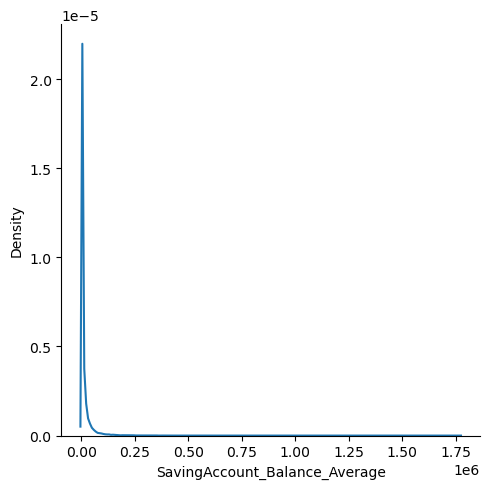

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a distribution plot
sns.displot(customer_universe['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [299]:
# There are a lot of customers that don't use the Saving Account. We need to focus into those who do use it.

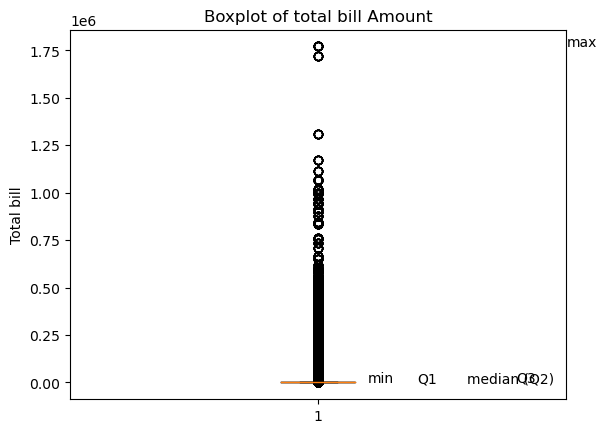

In [300]:
plt.boxplot(customer_universe['SavingAccount_Balance_Average'])

# add labels for five number summary
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].min(), s='min')
plt.text(x = 1.2, y = customer_universe['SavingAccount_Balance_Average'].quantile(0.25), s='Q1')
plt.text(x = 1.3, y = customer_universe['SavingAccount_Balance_Average'].median(), s='median (Q2)')
plt.text(x = 1.4, y = customer_universe['SavingAccount_Balance_Average'].quantile(0.75), s='Q3')
plt.text(x = 1.5, y = customer_universe['SavingAccount_Balance_Average'].max(), s='max')

plt.title('Boxplot of total bill Amount')
plt.ylabel('Total bill')

plt.show()

##### In the above graph, we can see the strong influence of the zeroes. In order to analyze better we need to filter the zeroes and the low values

In [301]:
#Saving Accounts with balance >0 in order to focus in those customers that really use their accounts
# In this case, we analyze those who have more than equivalent to 100 U.S. Dollars
saving_accounts_positive = customer_universe[customer_universe.SavingAccount_Balance_Average > 1000]
print('Registries with Savings Account positive')
print(saving_accounts_positive.shape)

Registries with Savings Account positive
(546336, 66)


In [302]:
customer_universe[['SavingAccount_Balance_Average']].describe()

,SavingAccount_Balance_Average
count,1.878471e+06
mean,4.223915e+03
std,2.278526e+04
min,-5.665900e+02
25%,0.000000e+00
50%,1.062000e+01
75%,1.484320e+03
max,1.771201e+06


##### From the table above, we can see that quantile 0.25 has Zero in their account

In [303]:
saving_accounts_positive[['SavingAccount_Balance_Average']].describe()

,SavingAccount_Balance_Average
count,5.463360e+05
mean,1.428377e+04
std,4.052454e+04
min,1.000010e+03
25%,1.995475e+03
50%,4.165715e+03
75%,1.112809e+04
max,1.771201e+06


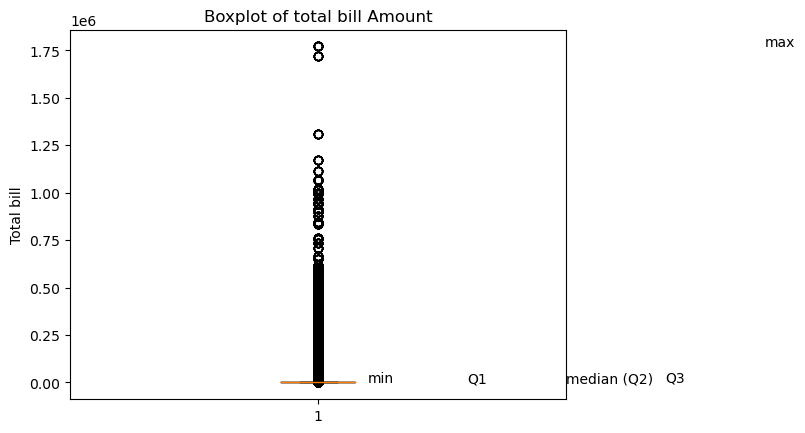

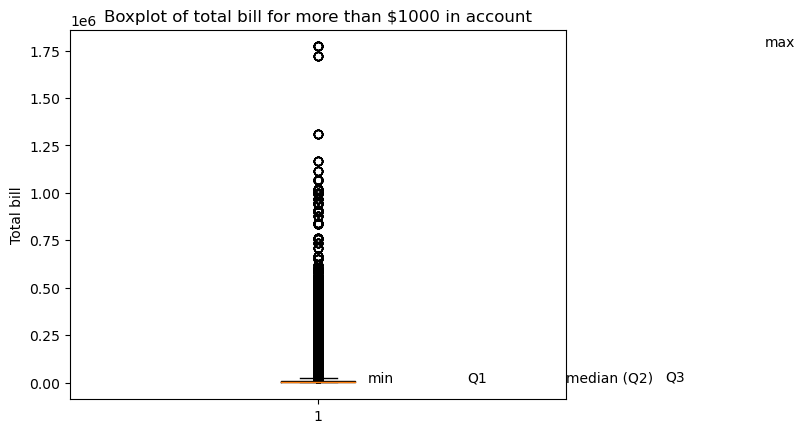

In [304]:
plt.boxplot(customer_universe['SavingAccount_Balance_Average'])

# add labels for five number summary
plt.text(x = 1.1, y = customer_universe['SavingAccount_Balance_Average'].min(), s='min')
plt.text(x = 1.3, y = customer_universe['SavingAccount_Balance_Average'].quantile(0.25), s='Q1')
plt.text(x = 1.5, y = customer_universe['SavingAccount_Balance_Average'].median(), s='median (Q2)')
plt.text(x = 1.7, y = customer_universe['SavingAccount_Balance_Average'].quantile(0.75), s='Q3')
plt.text(x = 1.9, y = customer_universe['SavingAccount_Balance_Average'].max(), s='max')

plt.title('Boxplot of total bill Amount')
plt.ylabel('Total bill')

plt.show()

plt.boxplot(saving_accounts_positive['SavingAccount_Balance_Average'])

# add labels for five number summary
plt.text(x = 1.1, y = int(saving_accounts_positive['SavingAccount_Balance_Average'].min()), s='min')
plt.text(x = 1.3, y = int(saving_accounts_positive['SavingAccount_Balance_Average'].quantile(0.25)), s='Q1')
plt.text(x = 1.5, y = int(saving_accounts_positive['SavingAccount_Balance_Average'].median()), s='median (Q2)')
plt.text(x = 1.7, y = int(saving_accounts_positive['SavingAccount_Balance_Average'].quantile(0.75)), s='Q3')
plt.text(x = 1.9, y = int(saving_accounts_positive['SavingAccount_Balance_Average'].max()), s='max')

plt.title('Boxplot of total bill for more than $1000 in account')
plt.ylabel('Total bill')

plt.show()


C:\Users\santi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


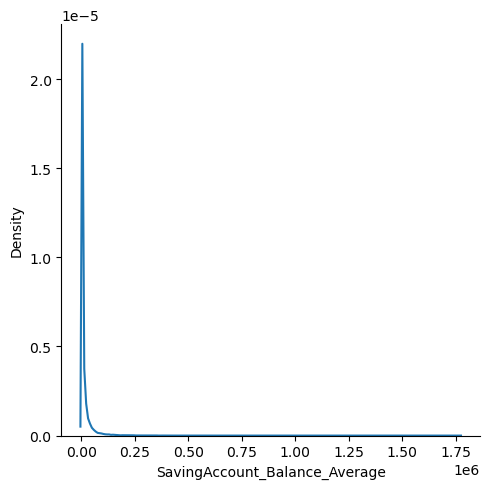

C:\Users\santi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


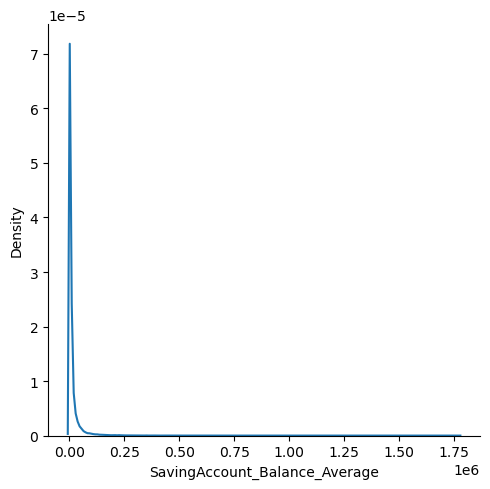

In [305]:
# plot a distribution plot
sns.displot(customer_universe['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()


# plot a distribution plot
sns.displot(saving_accounts_positive['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()



In [306]:
# getting the Top 5%
p95 = saving_accounts_positive['SavingAccount_Balance_Average'].quantile(0.95)
p99 = saving_accounts_positive['SavingAccount_Balance_Average'].quantile(0.99)
three_sigma = 3 * saving_accounts_positive['SavingAccount_Balance_Average'].std()
print('Top 5%: ', int(p95))
print('Top 1%: ', int(p99))
print('3 Sigma: ', int(three_sigma))

Top 5%:  55156
Top 1%:  164123
3 Sigma:  121573


In [307]:
print('We check the Remove those clients with top balance outliers by replacing their values with the 3 sigma.')
print('Before Replacing the max:')
print(customer_universe['SavingAccount_Balance_Average'].describe(), '\n')

customer_universe['SavingAccount_Balance_Average'] = np.where(
(customer_universe['SavingAccount_Balance_Average'] > three_sigma), three_sigma, customer_universe['SavingAccount_Balance_Average'])

print('Before Replacing the max:')
print(customer_universe['SavingAccount_Balance_Average'].describe())

We check the Remove those clients with top balance outliers by replacing their values with the 3 sigma.
Before Replacing the max:
count    1.878471e+06
mean     4.223915e+03
std      2.278526e+04
min     -5.665900e+02
25%      0.000000e+00
50%      1.062000e+01
75%      1.484320e+03
max      1.771201e+06
Name: SavingAccount_Balance_Average, dtype: float64 

Before Replacing the max:
count    1.878471e+06
mean     3.656799e+03
std      1.302763e+04
min     -5.665900e+02
25%      0.000000e+00
50%      1.062000e+01
75%      1.484320e+03
max      1.215736e+05
Name: SavingAccount_Balance_Average, dtype: float64


### 3.5 Create the Analytic Base Table

In [389]:
#identity_features
#aggregate_features
ABT = customers_universe_ids.merge(identity_features, how='right', on='client_id')\
                        .merge(aggregate_features,how='right', on='client_id')
ABT.shape

(23191, 506)

### Class 5 - Dimensionality Reduction

Use Case: Drop features with the following Behavior:

- Minimum = Maximum
- Unique Values
- Low Variance

In [415]:
#Dropping all registries where Minimum = Maximum
x = ABT.copy().describe().T
varsToDelete = x[x['min'] == x['max']].reset_index()
varsToDelete = x[x['min'] == x['max']].reset_index()
ABT.drop(varsToDelete['index'], axis=1, inplace=True)
ABT.shape


0        3
1        3
2        3
3        4
4        4
        ..
23186    3
23187    1
23188    3
23189    2
23190    1
Name: Client_Age_grp_ord, Length: 23191, dtype: int64

In [ ]:
#########################################33
###########################################
############################################
############################################
#ABT.drop(['Operations_Total_count_nonzero'], axis=1, inplace=True)

### 5.1 Remove correlated Features
The correlation test is used to evaluate the association between two or more variables

In [391]:
# If the correlation is > |80%| then we can discard one of the variables.
# For this purpose, we create the correlation matrix, focusing on the Credit Card fields:
#credit_card_columns = [ x for x in customer_universe if(x.startswith('CreditCard_Spending') & (~x.startswith('CreditCard_Payment_')))]
#credit_card_columns


In [392]:
#WoE: Weight of Evidence: It says how much information a certain variable provides. It can be used to decide which variable to discard.

#correlation_matrix = customer_universe.corr()
#pd.DataFrame(correlation_matrix).to_csv('|')

ABT_Numeric_Data = ABT[get_cols_int64(ABT)].drop(['client_id', 'TGT', 'Target', 'SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate'], axis=1)
print('Columns to Analyze its correlation Matrix')
print(ABT_Numeric_Data.shape)

ABT_corr_matrix = ABT_Numeric_Data.corr().abs()

#abt_corr_matrix = ABT_Numeric_Data.drop(['client_id', 'TGT', 'SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate'], axis=1).corr().abs()


print('Correlation Matrix: ')
print(ABT_corr_matrix.shape)


#upper_triangle_matrix = ABT_corr_matrix.where(np.triu(np.ones(abt_corr_matrix.shape), k=1).astype(np.bool)).fillna(0)
correlatedVariables = {}
for col in ABT_corr_matrix.columns:
        aux = [x for x in ABT_corr_matrix.columns if(x != col)]
        for x in aux:
            column1 = col
            column2 = x
            correlacion = ABT_corr_matrix[col][x]
            if(correlacion > 0.8 or correlacion < -0.8):
                if(column1 in correlatedVariables):
                    correlatedVariables[column1].append(column2)
                else:
                    correlatedVariables[column1] = [column2]
cols_to_take_off = []
for x,y in correlatedVariables.items():
    if(x not in cols_to_take_off):
        for colEliminar in y:
            cols_to_take_off.append(colEliminar)
cols_to_take_off = list(set(cols_to_take_off))

print('Number of columns to remove: ', len(to_take_off))

ABT.drop(cols_to_take_off, axis=1, inplace=True)
print('Printing the new ABT', ABT.shape)

#cols_to_drop = [ column for column in upper_triangle_matrix.columns if any(upper_triangle_matrix[column] > 0.8)]

#print('Columns to Drop: ')
#print(cols_to_drop)

#upper_triangle_matrix.reset_index().to_csv(r'C:\Users\santi\Documents\Desarrollo de Modelos Analíticos\TP Individual\matrixCorrelation.csv', \
#                                          sep='|', header=True, encoder='ANSI', index=False)



Columns to Analyze its correlation Matrix
(23191, 461)
Correlation Matrix: 
(461, 461)
Number of columns to remove:  294
Printing the new ABT (23191, 212)


In [406]:
ABT

,client_id,Target,SavingAccount_Balance_FirstDate,SavingAccount_Balance_LastDate,SavingAccount_Balance_Average,SavingAccount_Days_with_use,SavingAccount_Salary_Payment_Transactions,SavingAccount_Transfer_In_Transactions,SavingAccount_ATM_Extraction_Transactions,SavingAccount_Service_Payment_Transactions,...,Mobile_y_dummy_Yes,Loan_Active_y_dummy_Yes,CreditCard_Active_y_dummy_Yes,Mortgage_Active_y_dummy_Yes,SavingAccount_Active_ARG_y_dummy_Yes,SavingAccount_Active_DOLLAR_y_dummy_Yes,DebitCard_Active_y_dummy_Yes,Investment_Active_y_dummy_Yes,TGT,idx
0,1030,0.0,4858.68,756.31,1984.62,4.0,0.0,0.0,0.0,0.0,...,True,False,True,False,True,True,True,False,0,1030
1,1094,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,True,False,True,False,False,False,False,False,0,1094
2,1553,0.0,139.21,139.21,139.21,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,True,True,True,False,0,1553
3,1590,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,True,False,True,False,False,False,False,False,0,1590
4,1948,0.0,359.11,310.11,336.64,2.0,0.0,1.0,0.0,0.0,...,True,False,True,False,True,True,True,False,0,1948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,7344944,1.0,20.31,2000.76,88.95,5.0,5.0,0.0,9.0,0.0,...,True,False,False,False,True,False,True,False,1,7344944
23187,7345011,1.0,0.00,32.25,1244.17,8.0,4.0,0.0,8.0,0.0,...,True,False,False,False,True,False,True,False,1,7345011
23188,7345026,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,True,False,True,False,0,7345026
23189,7345029,0.0,2932.00,5035.11,1318.27,6.0,3.0,0.0,14.0,0.0,...,True,False,False,False,True,True,True,False,0,7345029


### 5.2 Transform Categoric Variables

In [399]:
typeColumns = ABT.dtypes.reset_index()
typeColumns.columns = ['column', 'type']
categoricalColumns = np.array(typeColumns[(typeColumns['type'] == 'object') & (typeColumns['column'] != 'client_id')]['column'])
ABT = pd.get_dummies(ABT, prefix_sep='_dummy_', columns=categoricalColumns, drop_first=True)
ABT.shape

(23191, 7031)

In [400]:
numericalColumns = [x for x in list(ABT.columns) if( x != 'TGT' and x != 'index' and x != 'idx' and 'region' not in x.lower())]
ABT = ABT[numericalColumns]


,client_id,Target,SavingAccount_Balance_FirstDate,SavingAccount_Balance_LastDate,SavingAccount_Balance_Average,SavingAccount_Days_with_use,SavingAccount_Salary_Payment_Transactions,SavingAccount_Transfer_In_Transactions,SavingAccount_ATM_Extraction_Transactions,SavingAccount_Service_Payment_Transactions,...,Client_Age_grp_y_dummy_Mayor a 70 años,Sex_y_dummy_M,Mobile_y_dummy_Yes,Loan_Active_y_dummy_Yes,CreditCard_Active_y_dummy_Yes,Mortgage_Active_y_dummy_Yes,SavingAccount_Active_ARG_y_dummy_Yes,SavingAccount_Active_DOLLAR_y_dummy_Yes,DebitCard_Active_y_dummy_Yes,Investment_Active_y_dummy_Yes
0,1030,0.0,4858.68,756.31,1984.62,4.0,0.0,0.0,0.0,0.0,...,False,False,True,False,True,False,True,True,True,False
1,1094,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,False,True,True,False,True,False,False,False,False,False
2,1553,0.0,139.21,139.21,139.21,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,False,False,True,True,True,False
3,1590,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,True,False,False,False,False,False
4,1948,0.0,359.11,310.11,336.64,2.0,0.0,1.0,0.0,0.0,...,False,False,True,False,True,False,True,True,True,False


### 5.3 Feature Selection

In [401]:
from sklearn.preprocessing import StandardScaler
    
auxTGT = customer_universe[['client_id','Target']].groupby('client_id').mean().reset_index()
ABT['TGT'] = np.where(auxTGT['Target'] == 1.0, 1, 0)
ABT['idx'] = ABT['client_id']

C:\Users\santi\AppData\Local\Temp\ipykernel_10332\2330754187.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ABT['TGT'] = np.where(auxTGT['Target'] == 1.0, 1, 0)
C:\Users\santi\AppData\Local\Temp\ipykernel_10332\2330754187.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ABT['idx'] = ABT['client_id']


In [402]:
# Running LightGBM
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

X_train, X_test = train_test_split(ABT, test_size= 0.2, random_state=314, stratify=ABT['TGT'])
def get_most_important_features(columns):
    fitParams = {
        # 'early_stopping_rounds': 1000,
        'eval_metric': 'auc',
        'eval_set': [X_test[columns],X_test['TGT']]
        }

    paramTest = {
        'num_leaves': np.arange(3, 10, 1),
        'min_child_samples': np.arange(200, 600, 100),
        'max_depth': np.arange(4, 10, 1),
        'n_estimators': np.arange(6, 10, 1),
        'learning_rate': [0.05,0.1,0.15,0.2],
        'verbosity': [-1],
    }

    nHPPointsToTest = 100
    clf = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', n_jobs=4, **fitParams)
    # crossVal = StratifiedKFold(n_splits=10)
    gs = RandomizedSearchCV(estimator=clf,param_distributions=paramTest,n_iter=nHPPointsToTest,
                            scoring='roc_auc',
                            # cv=crossVal,
                            # refit=True,
                            random_state=314,verbose=0)
    gs.fit(X_train[columns],X_train['TGT'])

    featImportance = pd.Series(gs.best_estimator_.feature_importances_, index=X_train[columns].columns)
    featImportance.nlargest(700).plot(kind='barh', figsize=(8,10))
    return (gs,featImportance)

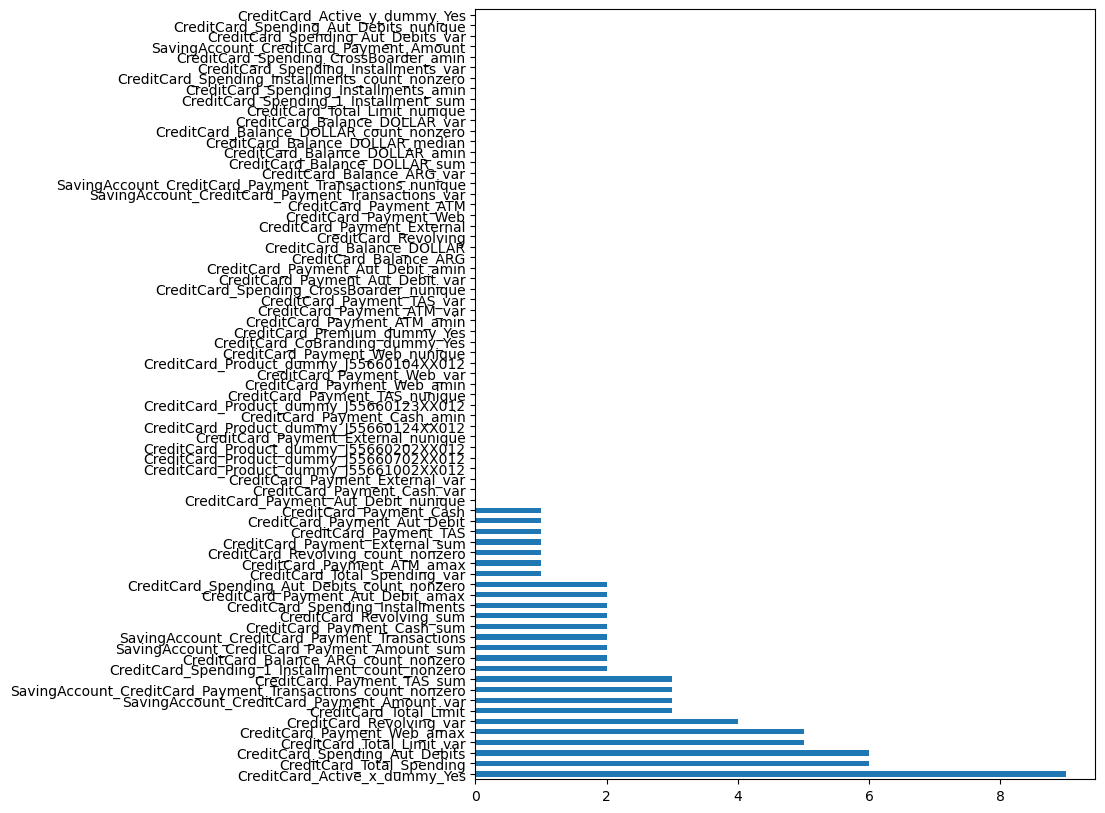

In [403]:
creditCardColumns = [x for x in list(ABT.columns) if('CreditCard' in x)]
gsCCard, featImportanceCCard = get_most_important_features(creditCardColumns)

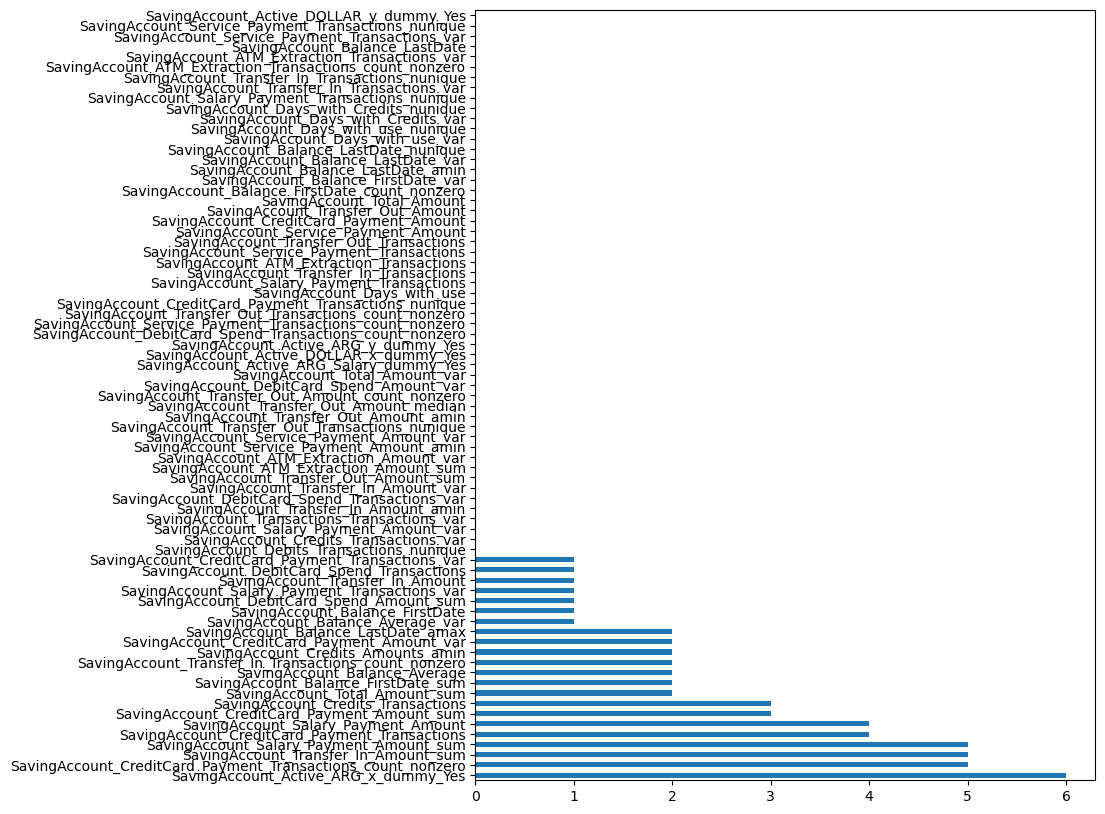

In [416]:
savingAccountColumns = [x for x in list(ABT.columns) if('SavingAccount' in x)]
gsSavingAccount, featImportanceSavingAccount = get_most_important_features(savingAccountColumns)

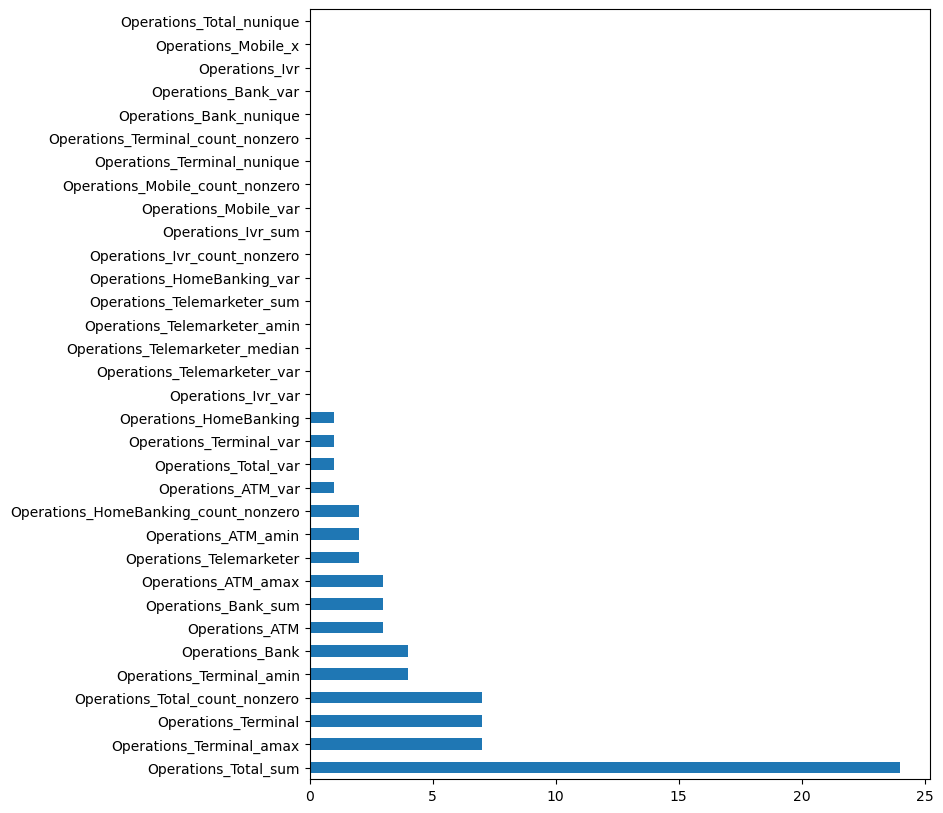

In [417]:
operationsColumns = [x for x in list(ABT.columns) if('Operations' in x)]
gsOperations, featImportanceOperations = get_most_important_features(operationsColumns)

In [426]:
BestCCard = pd.DataFrame({'name': featImportanceCCard.nlargest(5).index, 'weight': featImportanceCCard.nlargest(5).values})
BestSavingAccount = pd.DataFrame({'name': featImportanceSavingAccount.nlargest(5).index, 'weight': featImportanceSavingAccount.nlargest(5).values})
BestOperations = pd.DataFrame({'name': featImportanceOperations.nlargest(5).index, 'weight': featImportanceOperations.nlargest(5).values})
BestCCard = BestCCard[BestCCard['weight'] >= 7]
BestSavingAccount = BestSavingAccount[BestSavingAccount['weight'] >= 7]
BestOperations = BestOperations[BestOperations['weight'] >= 7]

selected_variables = []
for x in BestCCard.values:
    selected_variables.append(x[0])
for x in BestSavingAccount.values:
    selected_variables.append(x[0])
for x in BestOperations.values:
    selected_variables.append(x[0])

print('Variables seleccionadas:')
selected_variables = list(set(selected_variables))
for selected in selected_variables:
    print('\t \t' + selected)

Variables seleccionadas:
	 	Operations_Total_sum
	 	CreditCard_Active_x_dummy_Yes
	 	Operations_Terminal
	 	Operations_Total_count_nonzero
	 	Operations_Terminal_amax


In [431]:
# With the best variables we run again the model

best_parameters = gsSavingAccount.best_params_
parametros = {}

for key, val in best_parameters.items():
    parametros[key] = [val]

fitParams = {
    # 'early_stopping_rounds': 1000,
    "eval_metric": "auc",
    "eval_set": [X_test[selected_variables], X_test["TGT"]],
}

nHPPointsToTest = 100
clf_final_train = lgb.LGBMClassifier(
    random_state=314, silent=True, metric="None", n_jobs=4, **fitParams
)
# crossVal = StratifiedKFold(n_splits=10)
gsFinal = RandomizedSearchCV(
    estimator=clf_final_train,
    param_distributions=parametros,
    n_iter=nHPPointsToTest,
    scoring="roc_auc",
    refit=True,
    random_state=314,
    verbose=0,
)
gsFinal.fit(X_train[selected_variables], X_train["TGT"])

gsFinal.best_score_

C:\Users\santi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8040846688267997

### Evaluation of Performance

In [449]:
# Scoreo la base completa con el modelo final (mejores hiperparámetros)
probabilities_train = gsFinal.predict_proba(X_train[selected_variables])
probabilities_test = gsFinal.predict_proba(X_test[selected_variables])

# train
a = pd.DataFrame(X_train[['client_id', 'TGT']], columns=['TGT', 'idx'])
a = a.reset_index()
b = pd.DataFrame(probabilities_train[:, 1], columns=['Prob1'])

resultTrain = pd.concat([a, b], axis=1)
resultTrain['porc'] = resultTrain['Prob1'].rank(pct=True) * 100

# Calcular dinámicamente las cotas para el conjunto de entrenamiento, esto es lo que estaba en mi código
percentile_cutoffs_train = [np.percentile(probabilities_train[:, 1], i * 10) for i in range(1, 10)]
print(len([-np.inf] + percentile_cutoffs_train + [np.inf]))
resultTrain['decil'] = pd.cut(resultTrain['Prob1'], duplicates='drop', bins=[-np.inf] + percentile_cutoffs_train + [np.inf], labels=list(range(9, 0, -1)))

# Aplicando las cotas en el conjunto de prueba
##############################################
# test
a = pd.DataFrame(X_test[['TGT', 'client_id']], columns=['TGT', 'idx'])
a = a.reset_index()
b = pd.DataFrame(probabilities_test[:, 1], columns=['Prob1'])

# Usar las cotas calculadas en el conjunto de prueba
resultTest = pd.concat([a, b], axis=1)
resultTest['porc'] = resultTest['Prob1'].rank(pct=True) * 100
resultTest['decil'] = pd.cut(resultTest['Prob1'], duplicates='drop', bins=[-np.inf] + percentile_cutoffs_train + [np.inf], labels=list(range(9, 0, -1)))

# Función para balancear los deciles
def balancear_deciles(data, tgt_column, prob_column, percentile_cutoffs):
    data['decil'] = pd.cut(data[prob_column], duplicates='drop', bins=[-np.inf] + percentile_cutoffs + [np.inf], labels=list(range(9, 0, -1)))
    decil_counts = data.decil.value_counts().sort_index(ascending=False)
    min_decil_count = min(decil_counts)

    # Balancear los deciles
    balanced_data = pd.DataFrame()
    for decil in decil_counts.index:
        decil_data = data[data.decil == decil].sample(min_decil_count, replace=True)
        balanced_data = pd.concat([balanced_data, decil_data])

    return balanced_data

# Balancear el conjunto de entrenamiento
balanced_train = balancear_deciles(resultTrain, 'TGT', 'Prob1', percentile_cutoffs_train)

# Balancear el conjunto de prueba usando las cotas del conjunto de entrenamiento
balanced_test = balancear_deciles(resultTest, 'TGT', 'Prob1', percentile_cutoffs_train)

# Mostrar resultados balanceados
print('\tBALANCED TRAINING:')
print('TOTALES')
print(balanced_train.decil.value_counts().sort_index(ascending=False))
print('BUENOS')
print(balanced_train[balanced_train.TGT == 1].decil.value_counts().sort_index(ascending=False))

print('\tBALANCED TESTING:')
print('TOTALES')
print(balanced_test.decil.value_counts().sort_index(ascending=False))
print('BUENOS')
print(balanced_test[balanced_test.TGT == 1].decil.value_counts().sort_index(ascending=False))

11
	BALANCED TRAINING:
TOTALES
decil
1    555
2    555
3    555
4    555
5    555
6    555
7    555
8    555
9    555
Name: count, dtype: int64
BUENOS
decil
1    379
2    320
3    278
4    214
5    178
6    154
7    107
8     41
9      6
Name: count, dtype: int64
	BALANCED TESTING:
TOTALES
decil
1    147
2    147
3    147
4    147
5    147
6    147
7    147
8    147
9    147
Name: count, dtype: int64
BUENOS
decil
1    106
2     70
3     59
4     51
5     46
6     42
7     40
8      7
9      1
Name: count, dtype: int64


In [450]:
totalesTraining = resultTrain.decil.value_counts()
buenosTraining = resultTrain[resultTrain.TGT == 1].decil.value_counts()
totalesTesting = resultTest.decil.value_counts()
buenosTesting = resultTest[resultTest.TGT == 1].decil.value_counts()

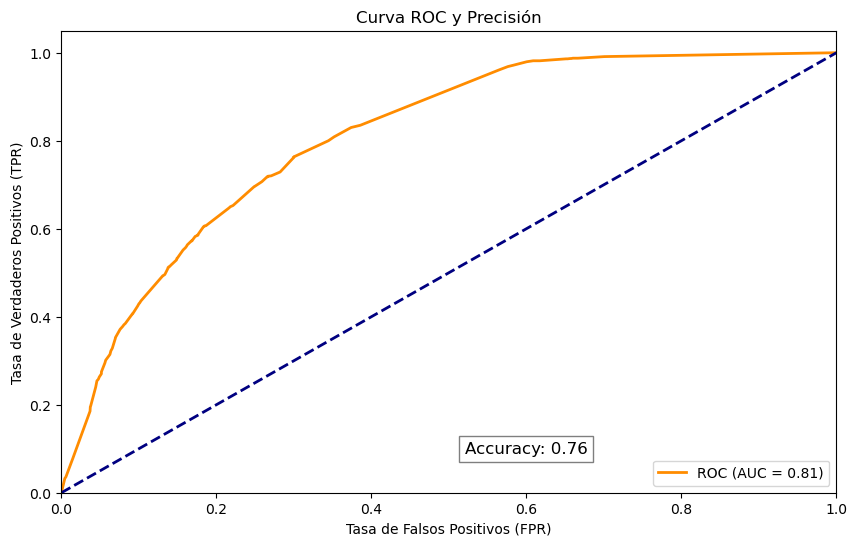

In [451]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Obtén las probabilidades predichas para el conjunto de prueba
y_probs = resultTest['Prob1']

# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(resultTest['TGT'], y_probs)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Calcula la precisión (accuracy)
y_pred = np.where(y_probs >= 0.5, 1, 0)
accuracy = accuracy_score(resultTest['TGT'], y_pred)

# Grafica la curva ROC y muestra la precisión en la leyenda
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC y Precisión')
plt.legend(loc='lower right')

# Muestra la accuracy en la leyenda
plt.text(0.6, 0.1, f'Accuracy: {accuracy:.2f}', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

# Variables seleccionadas:
	 	Operations_Total_sum: Operaciones totales realizadas
	 	CreditCard_Active_x_dummy_Yes: Clientes con Tarjeta de Crédito Activa
	 	Operations_Terminal: Operaciones Realizadas en un terminal ATM
	 	Operations_Total_count_nonzero: Clientes que
	 	Operations_Terminal_amax: Máxima cantidad de Operaciones Realizadas